# 🌍 Glacier Monitoring Using Satellite, Weather, and Climate Data

---

## 1. Project Introduction

This notebook explores glacier retreat trends using:
- Sentinel  Imagery
-  Weather Station Data
- ERA5 Climate Reanalysis

---aim to preprocess, analyze, engineer features, and build predictive models.

---




## 2. Library Imports

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Image & Geospatial
import rasterio
import geopandas as gpd
import folium
import cv2

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, r2_score

# Others
import os

# 3. Data Loading

 Found 15 weather station files.
['../data/glacier/weather_station/Janakpur_2963_en.json', '../data/glacier/weather_station/Birendranagar_2101_en.json', '../data/glacier/weather_station/Okhaldhunga_2965_en.json', '../data/glacier/weather_station/dhankuta_2102_en.json', '../data/glacier/weather_station/Jomsom_3509_en.json']
 Successfully combined all weather station data.
   month  maxTemp  minTemp meanTemp maxTempF minTempF meanTempF  raindays  \
0      1     21.0      8.8     None     69.8     47.8      None       2.7   
1      2     25.4     10.7     None     77.7     51.3      None       2.7   
2      3     31.3     14.6     None     88.3     58.3      None       2.5   
3      4     36.1     19.9     None     97.0     67.8      None       3.2   
4      5     36.4     23.6     None     97.5     74.5      None       8.2   

   rainfall climateFromMemDate    station  latitude  longitude  
0      17.7         2020-06-11  Bhairahwa      27.5       83.4  
1      19.2         2020-06-11  B

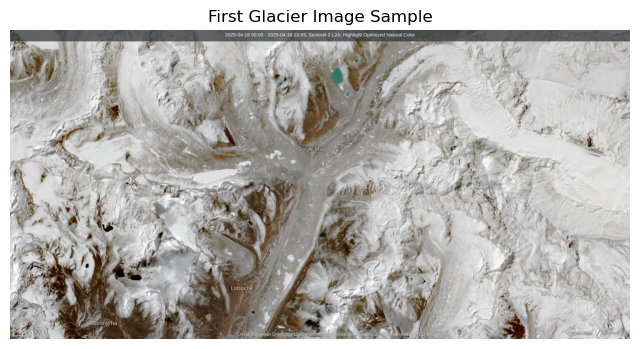

In [9]:
#  Imports
import os
import json



glacier_image_folder = "../data/glacier/glacier_images/"
weather_station_folder = "../data/glacier/weather_station/"

#  Load Glacier Images (List all JPEG files)
glacier_image_files = [os.path.join(glacier_image_folder, f)
                       for f in os.listdir(glacier_image_folder)
                       if f.lower().endswith('.jpg')]

#  Load Weather Station Files (List all JSON files)
weather_station_files = [os.path.join(weather_station_folder, f)
                          for f in os.listdir(weather_station_folder)
                          if f.endswith('.json')]

print(f" Found {len(weather_station_files)} weather station files.")
print(weather_station_files[:5])

#  Proper Weather Station Data Extraction
station_data_list = []

for file_path in weather_station_files:
    with open(file_path, 'r') as f:
        data = json.load(f)

    # Access the deep structure: city -> climate -> climateMonth
    city_data = data.get('city', {})
    climate_data = city_data.get('climate', {}).get('climateMonth', [])

    station_name = city_data.get('cityName', 'Unknown')
    latitude = city_data.get('cityLatitude', None)
    longitude = city_data.get('cityLongitude', None)

    # Build dataframe if climate data available
    if climate_data:
        df = pd.DataFrame(climate_data)
        df['station'] = station_name
        df['latitude'] = latitude
        df['longitude'] = longitude

        station_data_list.append(df)

#  Combine all station DataFrames
if station_data_list:
    weather_df = pd.concat(station_data_list, ignore_index=True)

    # Type Conversions
    weather_df['month'] = weather_df['month'].astype(int)
    weather_df['maxTemp'] = pd.to_numeric(weather_df['maxTemp'], errors='coerce')
    weather_df['minTemp'] = pd.to_numeric(weather_df['minTemp'], errors='coerce')
    weather_df['rainfall'] = pd.to_numeric(weather_df['rainfall'], errors='coerce')
    weather_df['raindays'] = pd.to_numeric(weather_df['raindays'], errors='coerce')
    weather_df['latitude'] = pd.to_numeric(weather_df['latitude'], errors='coerce')
    weather_df['longitude'] = pd.to_numeric(weather_df['longitude'], errors='coerce')

    # Sort
    weather_df = weather_df.sort_values(by=['station', 'month']).reset_index(drop=True)

    print(" Successfully combined all weather station data.")
    print(weather_df.head())

else:
    print(" No valid weather station data found!")

#  Save Combined Weather Data
output_folder = "../data/glacier/processed_weather_station/"
os.makedirs(output_folder, exist_ok=True)

weather_df.to_csv(os.path.join(output_folder, 'combined_weather_station.csv'), index=False)
print(" Weather station data saved to processed folder.")

#  Load and Show First Glacier Image
if glacier_image_files:
    img = cv2.imread(glacier_image_files[0])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(8,6))
    plt.imshow(img_rgb)
    plt.title("First Glacier Image Sample")
    plt.axis('off')
    plt.show()
else:
    print(" No glacier images found!")


In [10]:
import xarray as xr

# Load each dataset manually

data_stream_moda = xr.open_dataset('../data/glacier/ERA5/data_stream-moda.nc')


# Define a helper function
def print_dataset_info(name, ds):
    print(f"\nDataset: {name}")
    print("Available variables:")
    for var in ds.data_vars:
        print(f" - {var}")
    print("\nSample data (first 3 rows):")
    try:
        display_ds = ds.isel(time=slice(0, 3)) if 'time' in ds.dims else ds
        print(display_ds)
    except Exception as e:
        print(f"   Could not display sample data: {e}")
    print("-" * 100)

# Print manually one-by-one

print_dataset_info("data_stream-moda", data_stream_moda)




Dataset: data_stream-moda
Available variables:
 - d2m
 - t2m
 - skt
 - stl1
 - stl2
 - stl3
 - stl4
 - lblt
 - licd
 - lict
 - lmld
 - lmlt
 - lshf
 - ltlt
 - asn
 - snowc
 - rsn
 - sde
 - sd
 - sf
 - smlt
 - tsn
 - src
 - swvl1
 - swvl2
 - swvl3
 - swvl4
 - fal
 - slhf
 - ssr
 - str
 - sshf
 - ssrd
 - strd
 - evabs
 - evaow
 - evatc
 - evavt
 - pev
 - ro
 - es
 - ssro
 - sro
 - e
 - u10
 - v10
 - sp
 - tp
 - lai_hv
 - lai_lv

Sample data (first 3 rows):
<xarray.Dataset> Size: 9MB
Dimensions:     (valid_time: 903, latitude: 6, longitude: 8)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 7kB 1950-01-01 ... 2025-03-01
  * latitude    (latitude) float64 48B 28.2 28.1 28.0 27.9 27.8 27.7
  * longitude   (longitude) float64 64B 86.5 86.6 86.7 86.8 86.9 87.0 87.1 87.2
    expver      (valid_time) <U4 14kB ...
Data variables: (12/50)
    d2m         (valid_time, latitude, longitude) float32 173kB ...
    t2m         (valid_time, latitude, longitude) flo

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Path to glacier images
glacier_image_folder = "../data/glacier/glacier_images/"

# List all .jpg images
glacier_image_files = [os.path.join(glacier_image_folder, f)
                       for f in os.listdir(glacier_image_folder)
                       if f.lower().endswith('.jpg')]

print(f" Found {len(glacier_image_files)} glacier images.")

# Output folder
output_folder = "../data/glacier/processed_glacier_images/"
os.makedirs(output_folder, exist_ok=True)

# Standard size (choose based on balance between speed and quality)
TARGET_SIZE = (256, 256)  # (width, height)

for img_path in glacier_image_files:
    # Load image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Resize
    img_resized = cv2.resize(img_rgb, TARGET_SIZE, interpolation=cv2.INTER_AREA)
    
    # Normalize
    img_normalized = img_resized / 255.0  # Convert pixel values to [0.0, 1.0]
    
    #  Apply smoothing (denoising)
    img_normalized = cv2.GaussianBlur(img_normalized, (3, 3), 0)
    
    # Save the resized normalized image back
    filename = os.path.basename(img_path)
    save_path = os.path.join(output_folder, filename)
    
    # Save as normalized JPEG (reconvert to 0-255 range)
    img_to_save = (img_normalized * 255).astype(np.uint8)
    img_to_save = cv2.cvtColor(img_to_save, cv2.COLOR_RGB2BGR)  # Convert back to BGR to save
    cv2.imwrite(save_path, img_to_save)

print(" All glacier images resized and normalized successfully!")


 Found 190 glacier images.
 All glacier images resized and normalized successfully!


# Create a Glacier Image Timeline

In [12]:
import os
import cv2
import matplotlib.pyplot as plt
from datetime import datetime

#  Folder where processed glacier images are stored
processed_glacier_folder = "../data/glacier/processed_glacier_images/"

#  List all image files
glacier_image_files = [os.path.join(processed_glacier_folder, f)
                       for f in os.listdir(processed_glacier_folder)
                       if f.lower().endswith('.jpg')]

#  Extract dates properly
image_date_pairs = []

for img_path in glacier_image_files:
    filename = os.path.basename(img_path)
    try:
        # Correct: extract first 10 characters (YYYY-MM-DD)
        date_str = filename[:10]  # e.g., '2017-01-08'
        date_obj = datetime.strptime(date_str, "%Y-%m-%d")
        image_date_pairs.append((img_path, date_obj))
    except Exception as e:
        print(f" Skipping file {filename} due to date parsing error: {e}")

#  Sort images chronologically
image_date_pairs.sort(key=lambda x: x[1])

print(f" Total valid glacier images: {len(image_date_pairs)}")




 Total valid glacier images: 190


In [13]:
import os
import cv2
import matplotlib.pyplot as plt
import imageio
from datetime import datetime
import numpy as np

#  Processed Glacier Images Folder
processed_glacier_folder = "../data/glacier/processed_glacier_images/"

#  List all image files
glacier_image_files = [os.path.join(processed_glacier_folder, f)
                       for f in os.listdir(processed_glacier_folder)
                       if f.lower().endswith('.jpg')]

#  Extract dates properly
image_date_pairs = []

for img_path in glacier_image_files:
    filename = os.path.basename(img_path)
    try:
        date_str = filename[:10]  # YYYY-MM-DD
        date_obj = datetime.strptime(date_str, "%Y-%m-%d")
        image_date_pairs.append((img_path, date_obj))
    except Exception as e:
        print(f" Skipping {filename} - {e}")

#  Sort chronologically
image_date_pairs.sort(key=lambda x: x[1])

#  Create frames
frames = []
FADE_STEPS = 10  # Number of transition frames between two images

for i in range(len(image_date_pairs) - 1):
    img_path_a, date_a = image_date_pairs[i]
    img_path_b, date_b = image_date_pairs[i+1]
    
    # Load both images
    img_a = cv2.imread(img_path_a)
    img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB)
    img_a = cv2.resize(img_a, (512, 512))
    
    img_b = cv2.imread(img_path_b)
    img_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2RGB)
    img_b = cv2.resize(img_b, (512, 512))
    
    # Add original frame
    frames.append(img_a)
    
    # Add fade transition frames
    for alpha in np.linspace(0, 1, FADE_STEPS):
        blended = cv2.addWeighted(img_a, 1-alpha, img_b, alpha, 0)
        frames.append(blended)

# Add the final image
img_final = cv2.imread(image_date_pairs[-1][0])
img_final = cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB)
img_final = cv2.resize(img_final, (512, 512))
frames.append(img_final)

print(f" Total frames generated including fades: {len(frames)}")

#  Save the smooth glacier GIF
output_gif_path = "../data/glacier/processed_glacier_images/glacier_timelapse_smooth.gif"
imageio.mimsave(output_gif_path, frames, fps=5)  # Higher fps because we have more frames now

print(f" Smooth Glacier time-lapse GIF saved at {output_gif_path}")


 Total frames generated including fades: 2080
 Smooth Glacier time-lapse GIF saved at ../data/glacier/processed_glacier_images/glacier_timelapse_smooth.gif


In [14]:
import imageio_ffmpeg as ffmpeg

#  Save as MP4 video
output_video_path = "../data/glacier/processed_glacier_images/glacier_timelapse.mp4"
imageio.mimsave(output_video_path, frames, fps=2, codec='libx264')

print(f" Glacier time-lapse video saved at {output_video_path}")


 Glacier time-lapse video saved at ../data/glacier/processed_glacier_images/glacier_timelapse.mp4


# Glacier Area Extraction

 Total glacier images: 190


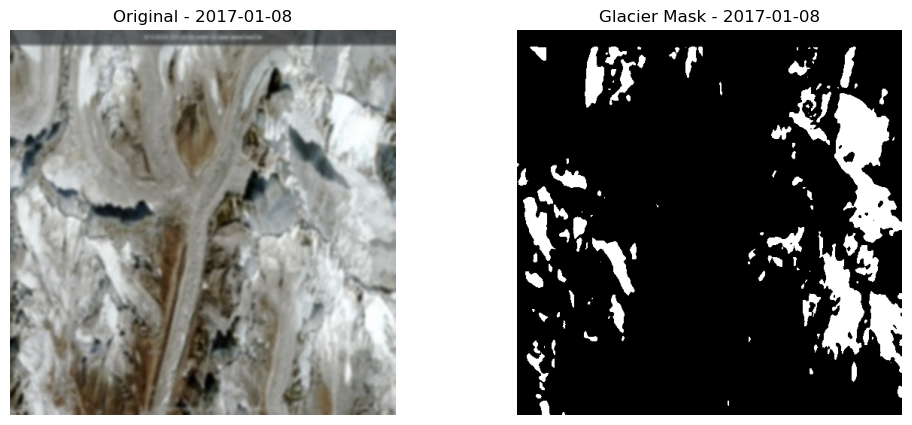

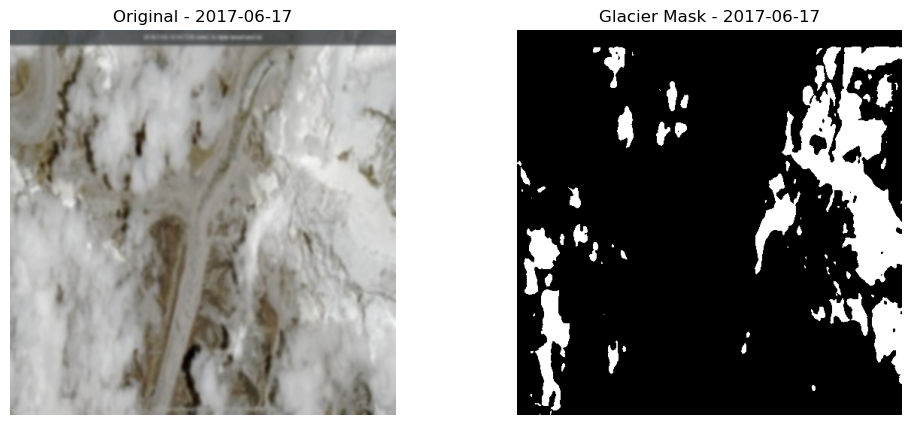

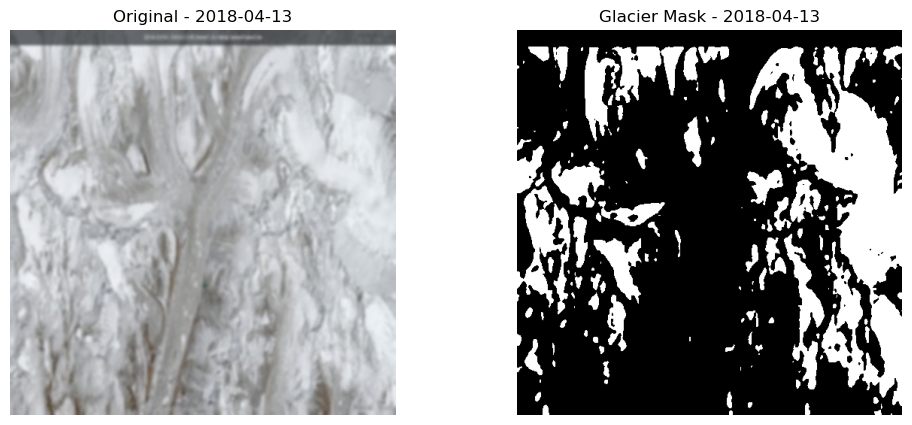

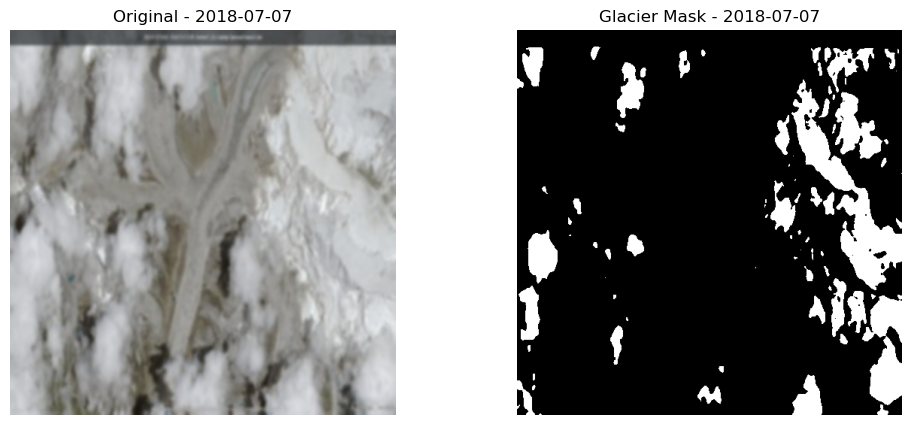

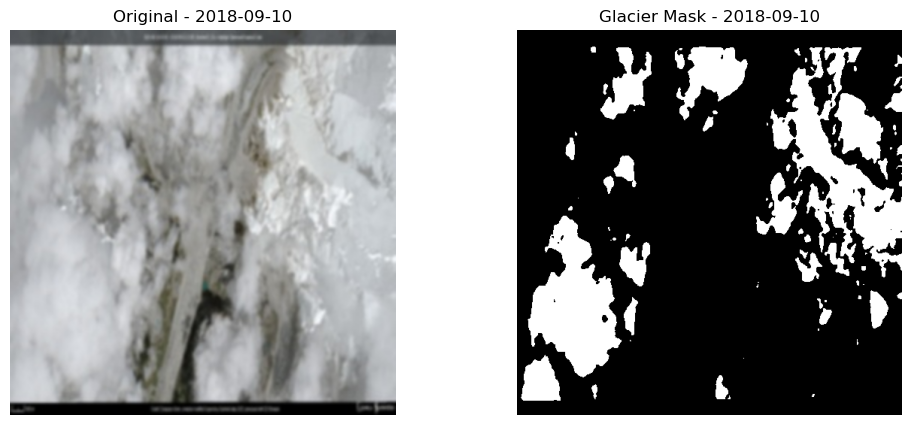

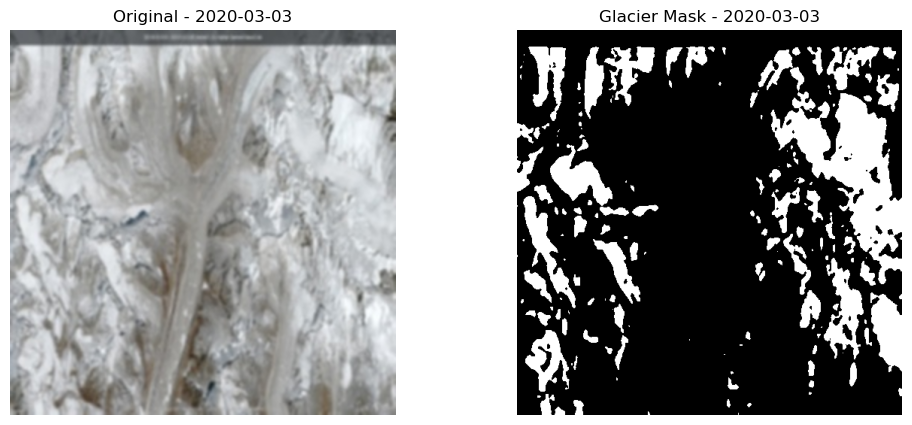

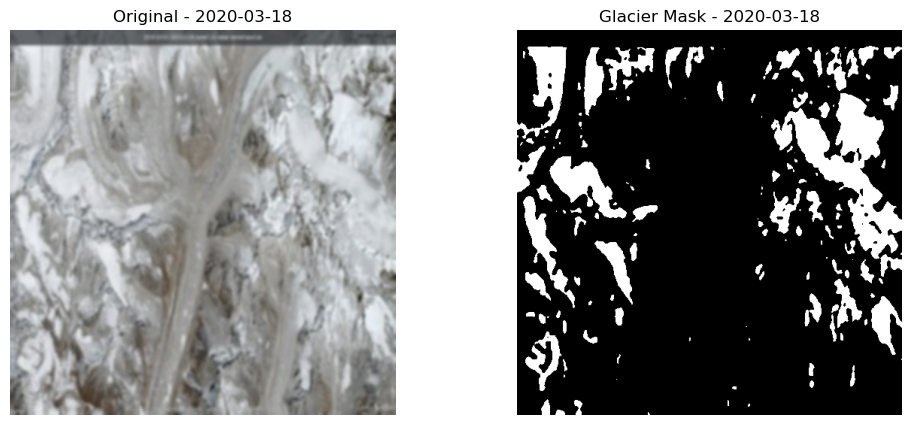

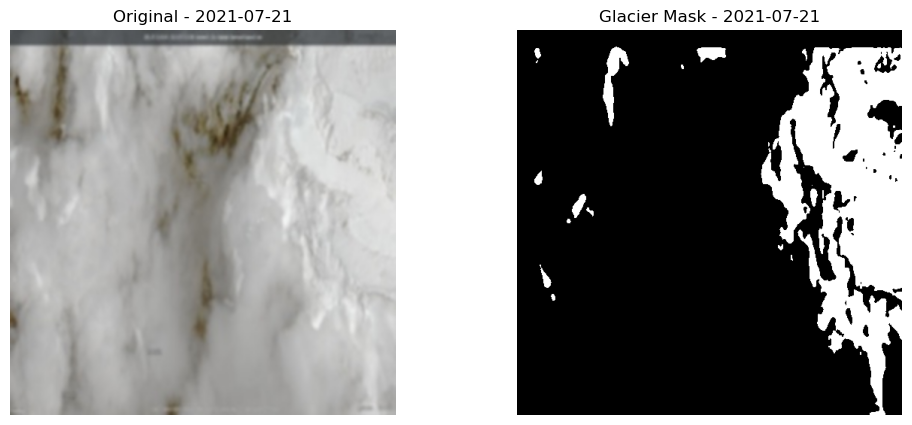

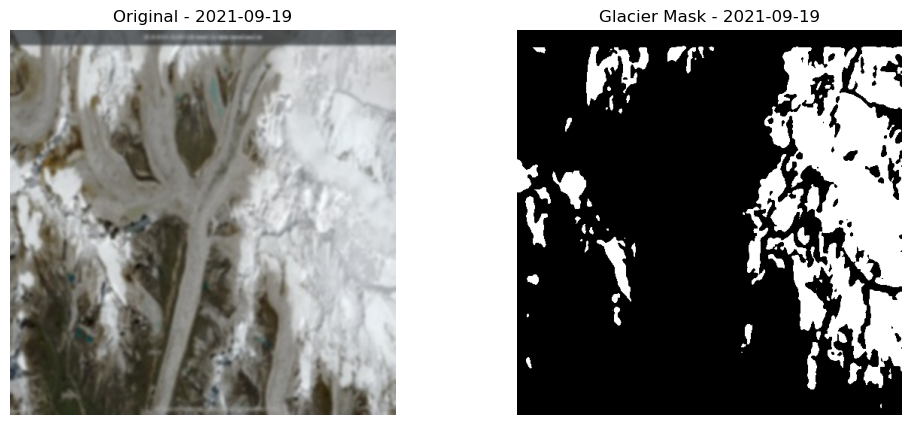

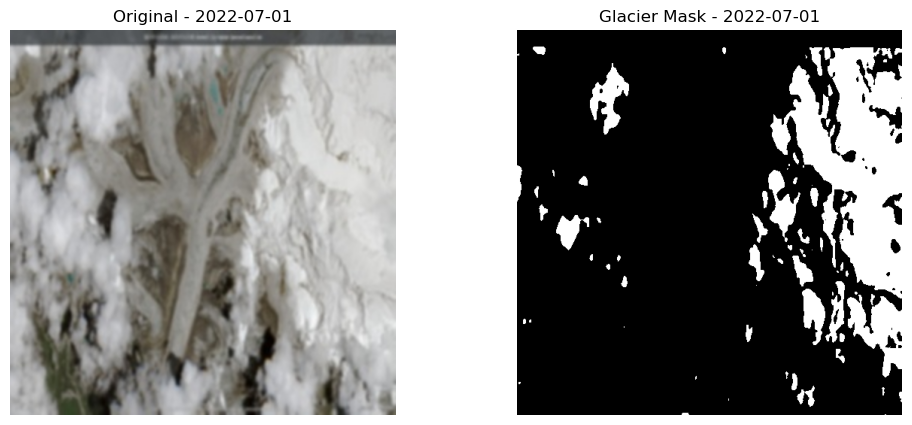

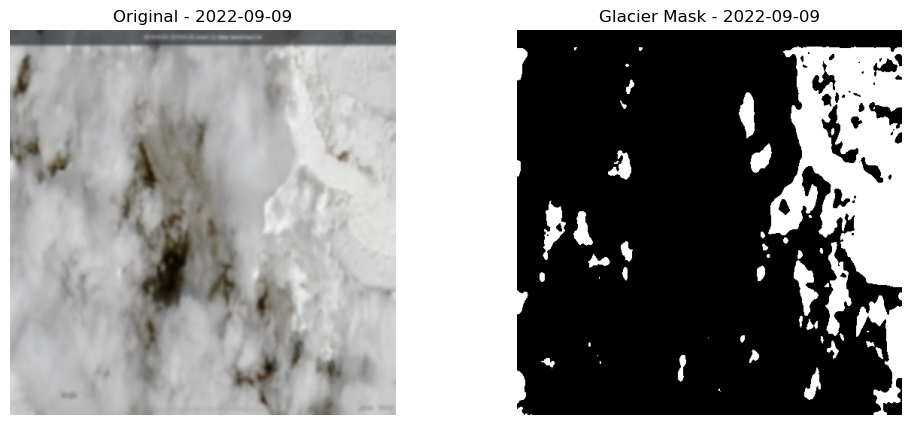

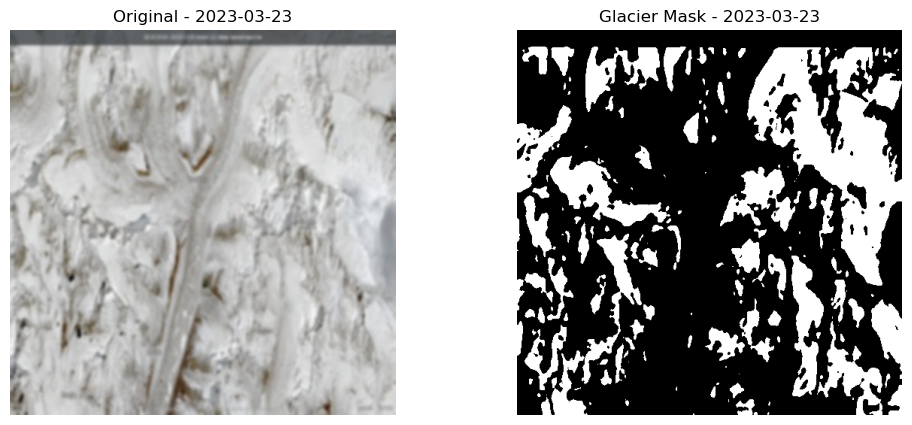

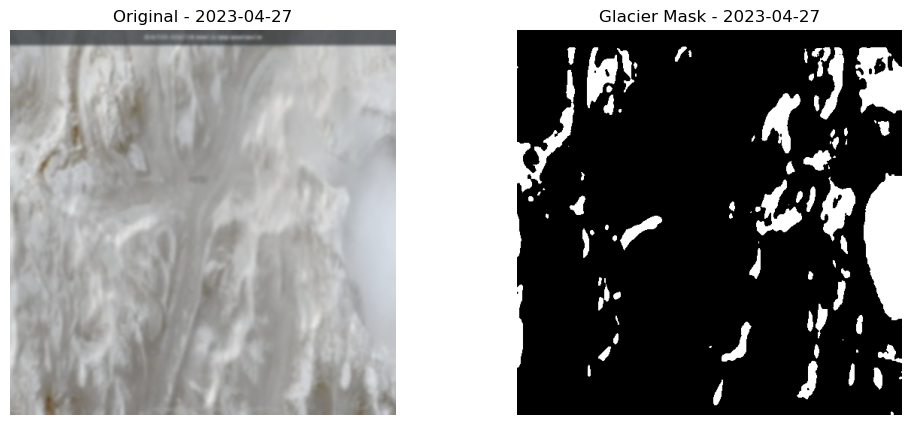

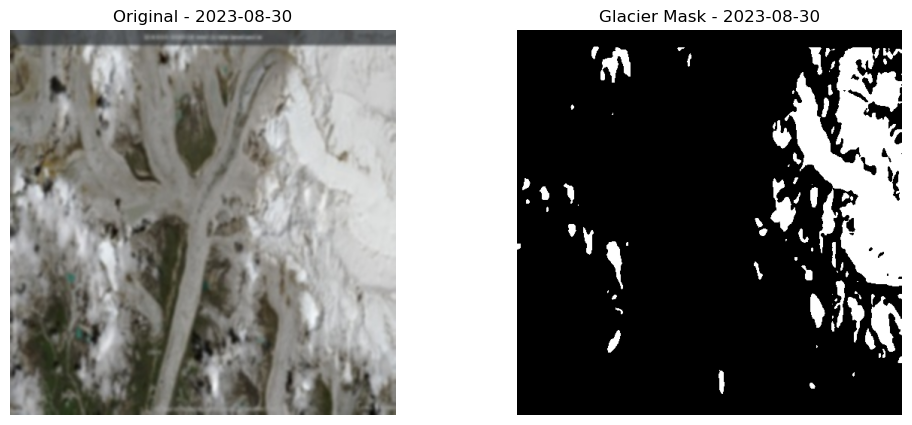

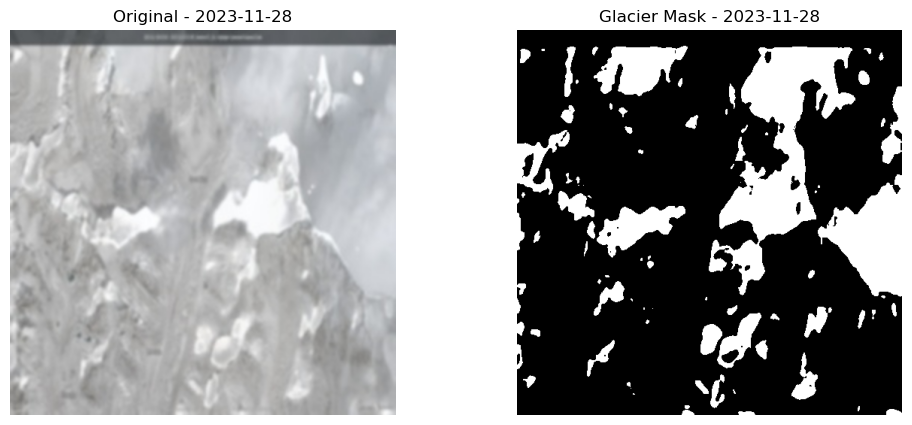

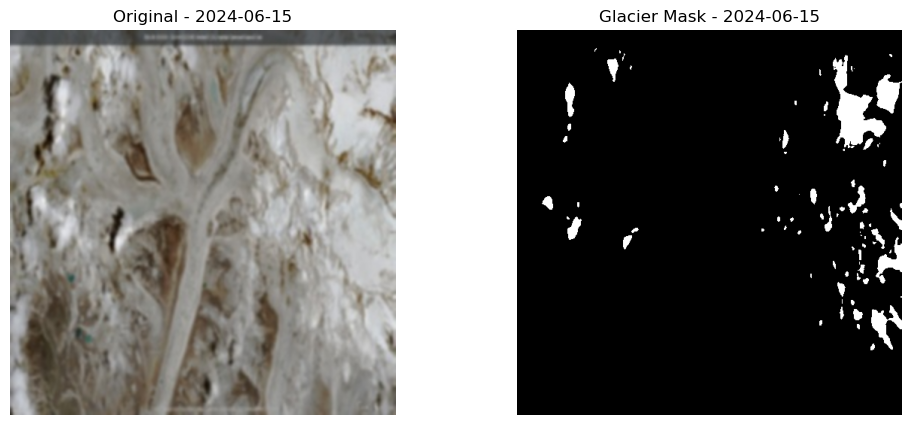

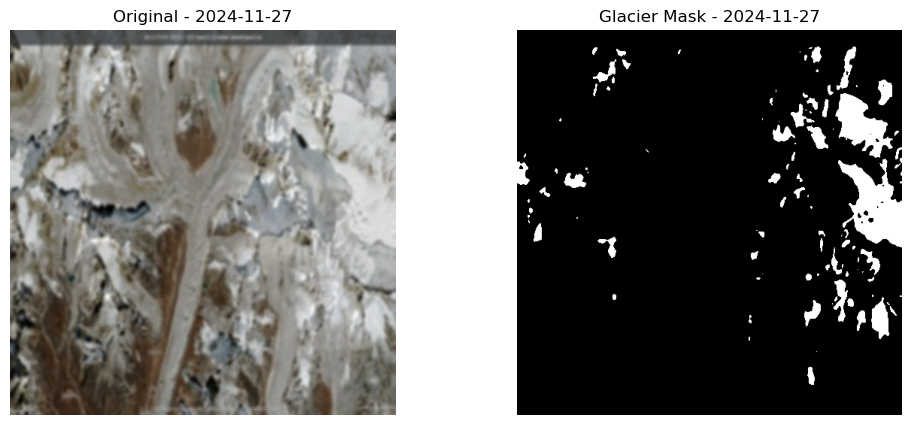

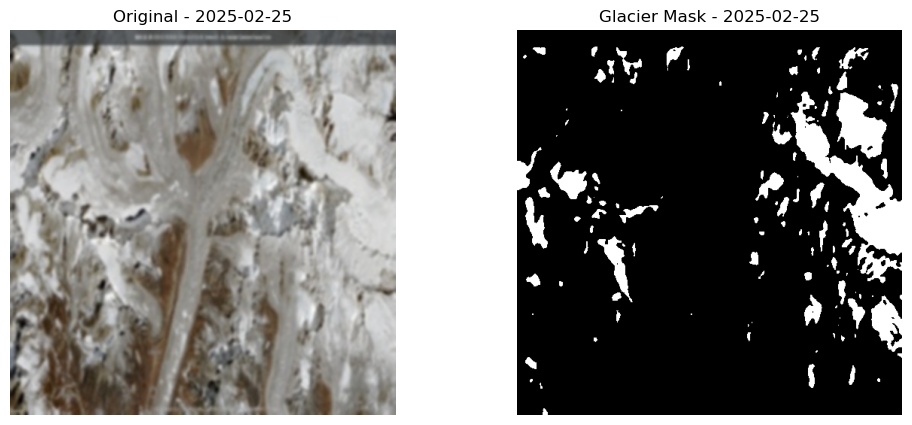

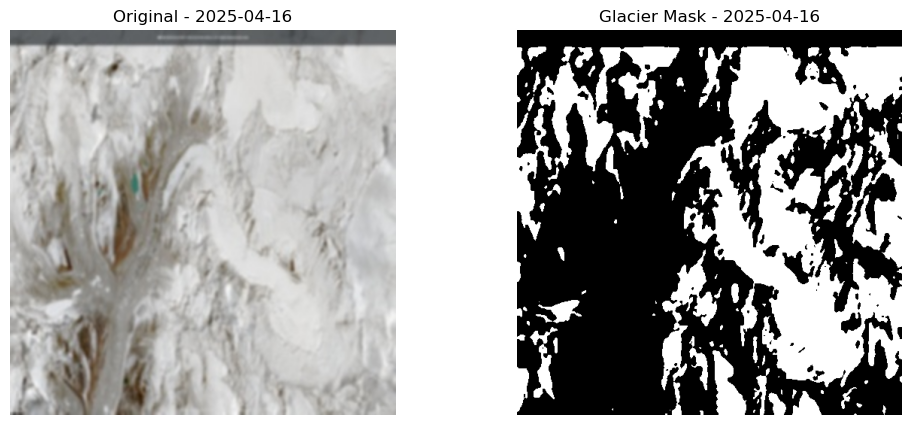

In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

processed_glacier_folder = "../data/glacier/processed_glacier_images/"

glacier_image_files = [os.path.join(processed_glacier_folder, f)
                       for f in os.listdir(processed_glacier_folder)
                       if f.lower().endswith('.jpg')]

# Extract dates
image_date_pairs = []

for img_path in glacier_image_files:
    filename = os.path.basename(img_path)
    try:
        date_str = filename[:10]  # YYYY-MM-DD
        date_obj = datetime.strptime(date_str, "%Y-%m-%d")
        image_date_pairs.append((img_path, date_obj))
    except Exception as e:
        print(f" Skipping {filename} - {e}")

# Sort by date
image_date_pairs.sort(key=lambda x: x[1])

print(f" Total glacier images: {len(image_date_pairs)}")

def extract_glacier_area(img_rgb, threshold_value=200):
    """
    Estimate glacier area by thresholding brightness.
    """
    # Convert to grayscale
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    
    # Apply threshold
    _, glacier_mask = cv2.threshold(img_gray, threshold_value, 255, cv2.THRESH_BINARY)
    
    # Count glacier pixels
    glacier_pixel_count = np.sum(glacier_mask == 255)
    
    # Total pixels
    total_pixel_count = glacier_mask.size
    
    # Area percentage
    glacier_area_percent = (glacier_pixel_count / total_pixel_count) * 100
    
    return glacier_area_percent, glacier_mask


area_trend = []

for img_path, date_obj in image_date_pairs:
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_rgb = cv2.resize(img_rgb, (512, 512))
    
    glacier_area_percent, glacier_mask = extract_glacier_area(img_rgb)
    
    area_trend.append({
        'date': date_obj,
        'glacier_area_percent': glacier_area_percent
    })
    
    # (Optional) Show few masks
    if np.random.rand() < 0.1:  # Randomly show ~10% samples
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img_rgb)
        plt.title(f"Original - {date_obj.date()}")
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.imshow(glacier_mask, cmap='gray')
        plt.title(f"Glacier Mask - {date_obj.date()}")
        plt.axis('off')
        
        plt.show()


In [28]:
# from IPython.display import HTML
# from base64 import b64encode

# #  Video File Path
# video_path = "../data/glacier/processed_glacier_images/glacier_timelapse.mp4"

# # Read and Encode Video
# mp4 = open(video_path, 'rb').read()
# data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

# #  Display in HTML
# HTML(f"""
# <video width=800 controls autoplay loop>
#     <source src="{data_url}" type="video/mp4">
# </video>
# """)


## Visualize Glacier Area Trend Over Time

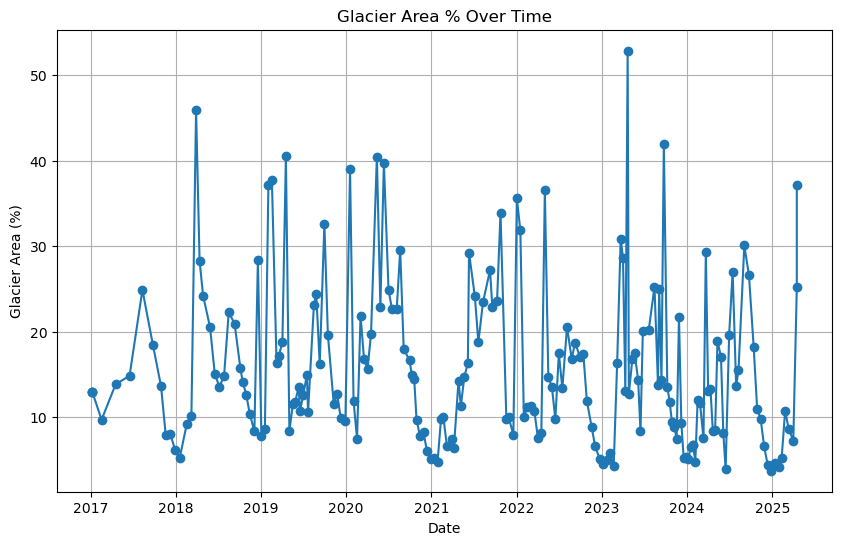

In [17]:
# Create DataFrame
import pandas as pd

area_df = pd.DataFrame(area_trend)

# Sort by date
area_df = area_df.sort_values('date')

# Plot the glacier area trend over time
plt.figure(figsize=(10,6))
plt.plot(area_df['date'], area_df['glacier_area_percent'], marker='o')
plt.title("Glacier Area % Over Time")
plt.ylabel("Glacier Area (%)")
plt.xlabel("Date")
plt.grid(True)
plt.show()


In [18]:
area_df.to_csv("../data/glacier/processed_glacier_images/glacier_area_trend.csv", index=False)


## Proceed to Glacier Prediction Modeling!

### 1: Prepare Glacier Area Data

In [19]:
import pandas as pd

# Load area data
area_df = pd.read_csv("../data/glacier/processed_glacier_images/glacier_area_trend.csv")

# Ensure 'date' is datetime
area_df['date'] = pd.to_datetime(area_df['date'])

# Extract 'year' or 'ordinal' numeric features
area_df['year'] = area_df['date'].dt.year
area_df['date_ordinal'] = area_df['date'].map(lambda x: x.toordinal())

print(area_df.head())


        date  glacier_area_percent  year  date_ordinal
0 2017-01-08             12.972641  2017        736337
1 2017-01-08             12.972641  2017        736337
2 2017-01-08             12.972641  2017        736337
3 2017-02-17              9.708023  2017        736377
4 2017-04-18             13.845444  2017        736437


### 2: Build Baseline Regression Model

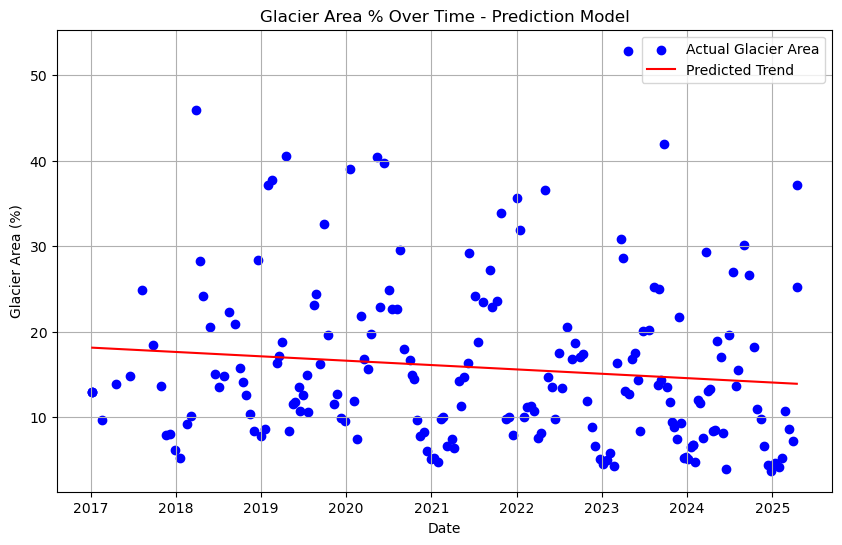

 Model Coefficient (slope): -0.001398
 Model Intercept: 1047.225522


In [20]:
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt

# Features (time)
X = area_df['date_ordinal'].values.reshape(-1, 1)

# Target (glacier area %)
y = area_df['glacier_area_percent'].values

# Model
model = LinearRegression()
model.fit(X, y)

# Predict
y_pred = model.predict(X)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(area_df['date'], y, label='Actual Glacier Area', color='blue')
plt.plot(area_df['date'], y_pred, label='Predicted Trend', color='red')
plt.title("Glacier Area % Over Time - Prediction Model")
plt.ylabel("Glacier Area (%)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

print(f" Model Coefficient (slope): {model.coef_[0]:.6f}")
print(f" Model Intercept: {model.intercept_:.6f}")


### 3: Predict Future Glacier Area

/tmp/ipykernel_45850/3360013145.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_years = pd.date_range(start=area_df['date'].max(), periods=60, freq='M')


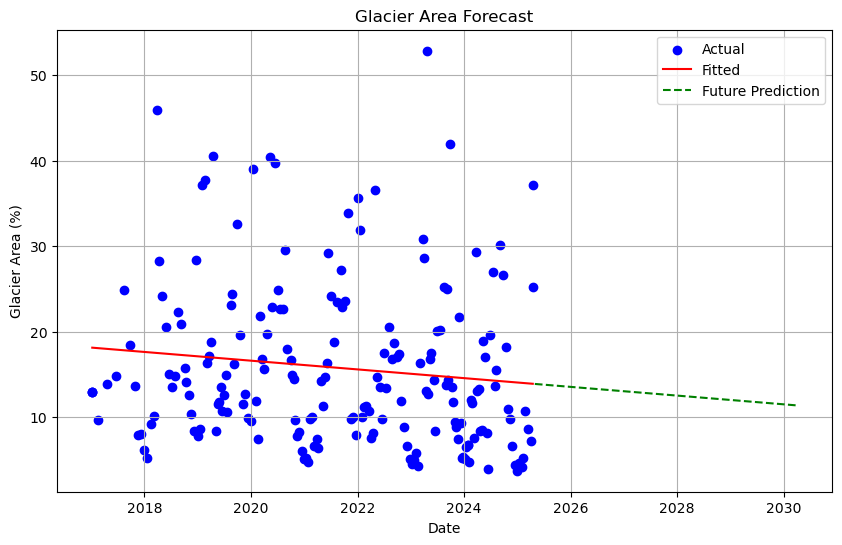

In [21]:
# Predict into the future
future_years = pd.date_range(start=area_df['date'].max(), periods=60, freq='M')

future_X = future_years.map(lambda x: x.toordinal()).values.reshape(-1, 1)
future_preds = model.predict(future_X)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(area_df['date'], y, label='Actual', color='blue')
plt.plot(area_df['date'], y_pred, label='Fitted', color='red')
plt.plot(future_years, future_preds, '--', label='Future Prediction', color='green')
plt.title("Glacier Area Forecast")
plt.ylabel("Glacier Area (%)")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()


## Save Model for Future

In [22]:
import joblib

# Save the model
joblib.dump(model, "../models/glacier_area_linear_regression.pkl")
print(" Model saved!")


# if needed i can use the same model calling like this
# model = joblib.load("../models/glacier_area_linear_regression.pkl")


 Model saved!


# Advanced Glacier Modeling
### improving the model further by:

- Using ERA5 climate variables (temperature, snowfall) as features

- Trying polynomial regression or time series models (ARIMA, LSTM)

In [23]:
import xarray as xr
import pandas as pd

#  Load the ERA5 file
path = "../data/glacier/ERA5/data_stream-moda.nc"
ds = xr.open_dataset(path)

print(f" Dataset loaded with variables: {list(ds.data_vars)[:5]}...")

#  Select needed variables
selected_vars = ["t2m", "tp", "sf"]

#  Subset
ds_selected = ds[selected_vars]

#  Rename 'valid_time' -> 'time' for easier handling
ds_selected = ds_selected.rename({'valid_time': 'time'})

#  Spatial Mean (average across small grid)
ds_spatial_mean = ds_selected.mean(dim=["latitude", "longitude"])

print(f" Spatial averaging done.")

#  Convert time
ds_spatial_mean['time'] = pd.to_datetime(ds_spatial_mean['time'].values)

#  Group by year
df_yearly = ds_spatial_mean.to_dataframe().reset_index()
df_yearly['year'] = df_yearly['time'].dt.year

#  Aggregate yearly
climate_yearly = df_yearly.groupby('year')[selected_vars].mean().reset_index()

print(f" Yearly aggregation completed.")
print(climate_yearly.head())

#  Save output
output_path = "../data/glacier/ERA5/processed_era5_climate_glacier_ready.csv"
climate_yearly.to_csv(output_path, index=False)

print(f" Final cleaned ERA5 climate data saved to {output_path}")


 Dataset loaded with variables: ['d2m', 't2m', 'skt', 'stl1', 'stl2']...
 Spatial averaging done.
 Yearly aggregation completed.
   year         t2m        tp        sf
0  1950  267.450958  0.005514  0.002982
1  1951  266.846283  0.004331  0.001911
2  1952  266.966949  0.004677  0.002554
3  1953  266.849670  0.003975  0.001787
4  1954  267.196259  0.004476  0.001840
 Final cleaned ERA5 climate data saved to ../data/glacier/ERA5/processed_era5_climate_glacier_ready.csv


## 1: Merge Datasets


In [24]:
import pandas as pd

#  Load datasets
climate_df = pd.read_csv("../data/glacier/ERA5/processed_era5_climate_glacier_ready.csv")
glacier_df = pd.read_csv("../data/glacier/glacier_area_trend.csv")

#  Check columns
print("Climate columns:", climate_df.columns.tolist())
print("Glacier columns:", glacier_df.columns.tolist())

# 🛠 Fix glacier_df: Rename 'date' ➔ 'year'
if 'date' in glacier_df.columns:
    glacier_df.rename(columns={'date': 'year'}, inplace=True)

#  Convert glacier 'year' safely (from full date to year)
glacier_df['year'] = pd.to_datetime(glacier_df['year']).dt.year

#  Ensure climate year is integer
climate_df['year'] = climate_df['year'].astype(int)

#  Merge
merged_df = pd.merge(glacier_df, climate_df, on='year', how='inner')

print(f" Successfully merged! Shape: {merged_df.shape}")
print(merged_df.head())

#  Save
output_path = "../data/glacier/ERA5/merged_glacier_climate_modeling.csv"
merged_df.to_csv(output_path, index=False)

print(f" Merged dataset saved to {output_path}")


Climate columns: ['year', 't2m', 'tp', 'sf']
Glacier columns: ['date', 'glacier_area_percent']
 Successfully merged! Shape: (190, 5)
   year  glacier_area_percent        t2m       tp        sf
0  2017             12.972641  268.79016  0.00411  0.001398
1  2017             12.972641  268.79016  0.00411  0.001398
2  2017             12.972641  268.79016  0.00411  0.001398
3  2017              9.708023  268.79016  0.00411  0.001398
4  2017             13.845444  268.79016  0.00411  0.001398
 Merged dataset saved to ../data/glacier/ERA5/merged_glacier_climate_modeling.csv


# Modeling  ( Linear + Ridge + Poly)

   year  glacier_area_percent        t2m       tp        sf
0  2017             12.972641  268.79016  0.00411  0.001398
1  2017             12.972641  268.79016  0.00411  0.001398
2  2017             12.972641  268.79016  0.00411  0.001398
3  2017              9.708023  268.79016  0.00411  0.001398
4  2017             13.845444  268.79016  0.00411  0.001398

 Linear Regression Results:
R2 Score: -0.0572
MAE: 7.5876
MSE: 88.8799

 Ridge Regression Results:
R2 Score: -0.0048
MAE: 7.4250
MSE: 84.4758

 Polynomial Regression Results:
R2 Score: 0.0029
MAE: 7.2093
MSE: 83.8223


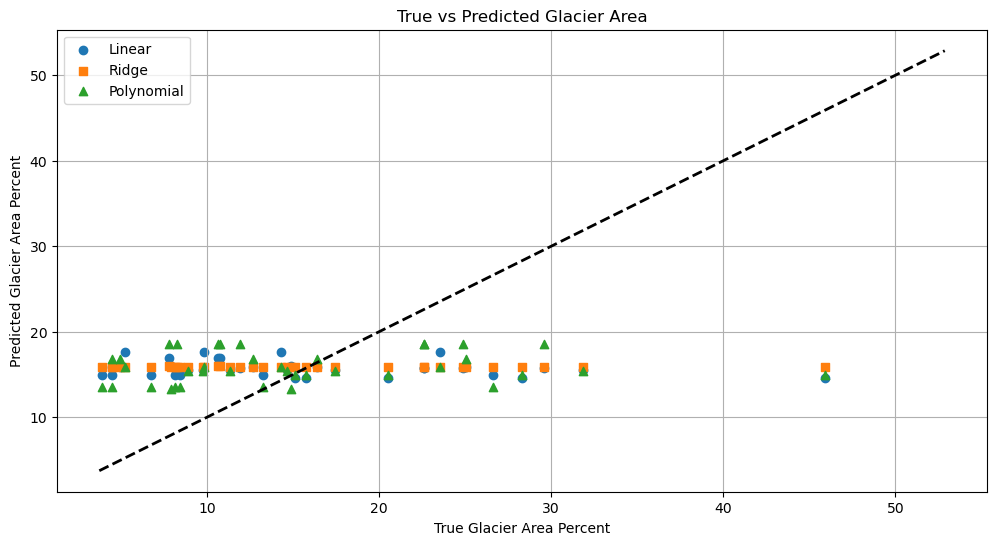

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#  Load merged dataset
df = pd.read_csv("../data/glacier/ERA5/merged_glacier_climate_modeling.csv")

print(df.head())

#  Features and Target
X = df[['t2m', 'tp', 'sf']]  # Climate variables
y = df['glacier_area_percent']  # Target

#  Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  1. Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

#  2. Ridge Regression
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)

#  3. Polynomial Regression (degree=2)
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)

#  Evaluate models
def evaluate_model(name, y_true, y_pred):
    print(f"\n {name} Results:")
    print(f"R2 Score: {r2_score(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")

evaluate_model("Linear Regression", y_test, y_pred_lin)
evaluate_model("Ridge Regression", y_test, y_pred_ridge)
evaluate_model("Polynomial Regression", y_test, y_pred_poly)

#  Plotting predictions vs true
plt.figure(figsize=(12,6))
plt.scatter(y_test, y_pred_lin, label="Linear", marker='o')
plt.scatter(y_test, y_pred_ridge, label="Ridge", marker='s')
plt.scatter(y_test, y_pred_poly, label="Polynomial", marker='^')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('True Glacier Area Percent')
plt.ylabel('Predicted Glacier Area Percent')
plt.legend()
plt.title("True vs Predicted Glacier Area")
plt.grid(True)
plt.show()


## Training the model


 Linear Regression Results:
R2 Score: -0.0572
MAE: 7.5876
MSE: 88.8799

 Ridge Regression Results:
R2 Score: -0.0048
MAE: 7.4250
MSE: 84.4758

 Polynomial Regression Results:
R2 Score: 0.0029
MAE: 7.2093
MSE: 83.8223
✅ Model evaluation results saved to model_metrics.csv


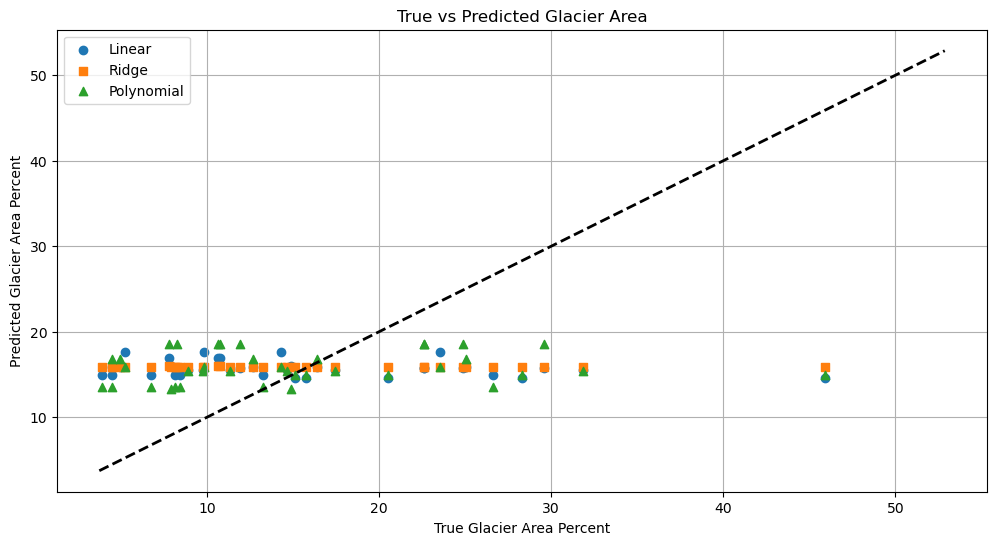

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

#  Load the merged dataset
df = pd.read_csv("../data/glacier/ERA5/merged_glacier_climate_modeling.csv")

#  Features and Target
X = df[['t2m', 'tp', 'sf']]  # Independent Variables (Climate)
y = df['glacier_area_percent']  # Dependent Variable (Glacier Area)

#  Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#  1. Linear Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

#  2. Ridge Regression Model
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)

#  3. Polynomial Regression Model (degree=2)
poly_model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
poly_model.fit(X_train, y_train)
y_pred_poly = poly_model.predict(X_test)

#  Model Evaluation Function
def evaluate_model(name, y_true, y_pred):
    print(f"\n {name} Results:")
    print(f"R2 Score: {r2_score(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.4f}")

#  Evaluate all models
evaluate_model("Linear Regression", y_test, y_pred_lin)
evaluate_model("Ridge Regression", y_test, y_pred_ridge)
evaluate_model("Polynomial Regression", y_test, y_pred_poly)

#  Save Model Metrics
model_results = {
    "Model": ["Linear Regression", "Ridge Regression", "Polynomial Regression"],
    "R2 Score": [
        r2_score(y_test, y_pred_lin),
        r2_score(y_test, y_pred_ridge),
        r2_score(y_test, y_pred_poly)
    ],
    "MAE": [
        mean_absolute_error(y_test, y_pred_lin),
        mean_absolute_error(y_test, y_pred_ridge),
        mean_absolute_error(y_test, y_pred_poly)
    ],
    "MSE": [
        mean_squared_error(y_test, y_pred_lin),
        mean_squared_error(y_test, y_pred_ridge),
        mean_squared_error(y_test, y_pred_poly)
    ]
}

metrics_df = pd.DataFrame(model_results)
metrics_df.to_csv("../data/glacier/ERA5/model_metrics.csv", index=False)

print("✅ Model evaluation results saved to model_metrics.csv")

#  Plot True vs Predicted
plt.figure(figsize=(12,6))
plt.scatter(y_test, y_pred_lin, label="Linear", marker='o')
plt.scatter(y_test, y_pred_ridge, label="Ridge", marker='s')
plt.scatter(y_test, y_pred_poly, label="Polynomial", marker='^')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('True Glacier Area Percent')
plt.ylabel('Predicted Glacier Area Percent')
plt.title('True vs Predicted Glacier Area')
plt.legend()
plt.grid(True)
plt.show()


# Forecasting Glacier Melt to 2050

Mean Climate values based on last 5 years: T2M=268.48, TP=0.0040, SF=0.0014

 Future Glacier Area Prediction:
    year  predicted_glacier_area_percent
0   2025                       15.852604
1   2026                       15.852604
2   2027                       15.852604
3   2028                       15.852604
4   2029                       15.852604
5   2030                       15.852604
6   2031                       15.852604
7   2032                       15.852604
8   2033                       15.852604
9   2034                       15.852604
10  2035                       15.852604
11  2036                       15.852604
12  2037                       15.852604
13  2038                       15.852604
14  2039                       15.852604
15  2040                       15.852604
16  2041                       15.852604
17  2042                       15.852604
18  2043                       15.852604
19  2044                       15.852604
20  2045                     

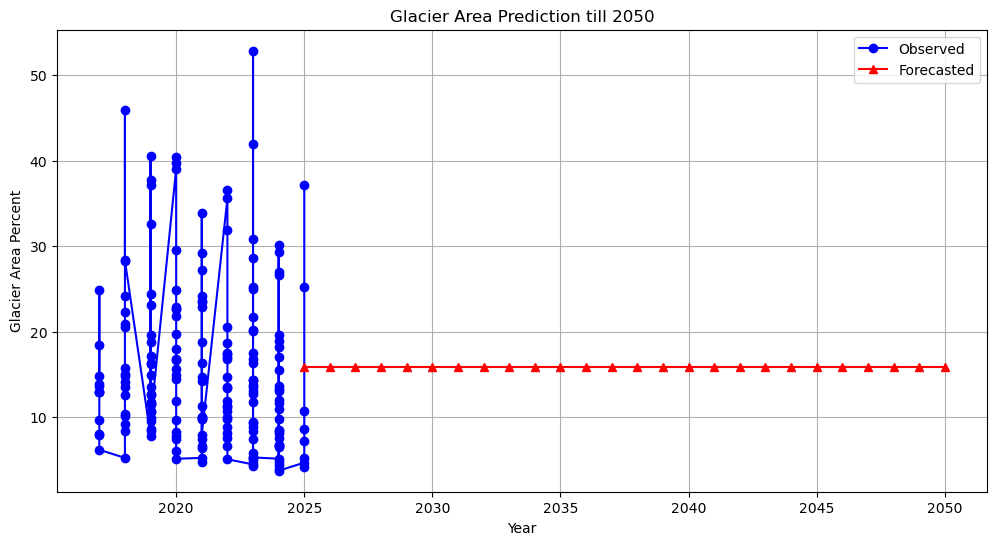

 Saved future glacier forecast to 'future_glacier_forecast.csv'


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# lin_reg trained LinearRegression model

#  1. Create Future Years
future_years = np.arange(2025, 2051)

#  2. Create Assumed Climate Features for Future
# --- Simple assumption: Use mean of last 5 years observed
last_years_df = df[df['year'] >= df['year'].max() - 5]

mean_t2m = last_years_df['t2m'].mean()
mean_tp = last_years_df['tp'].mean()
mean_sf = last_years_df['sf'].mean()

print(f"Mean Climate values based on last 5 years: T2M={mean_t2m:.2f}, TP={mean_tp:.4f}, SF={mean_sf:.4f}")

# Build DataFrame
future_climate_df = pd.DataFrame({
    'year': future_years,
    't2m': mean_t2m,
    'tp': mean_tp,
    'sf': mean_sf
})

# 3. Predict Future Glacier Area
future_X = future_climate_df[['t2m', 'tp', 'sf']]
future_predictions = lin_reg.predict(future_X)

# 4. Store Results
future_climate_df['predicted_glacier_area_percent'] = future_predictions

print("\n Future Glacier Area Prediction:")
print(future_climate_df[['year', 'predicted_glacier_area_percent']])

# 5. Plot Results
plt.figure(figsize=(12,6))

# Plot historical data
plt.plot(df['year'], df['glacier_area_percent'], 'bo-', label='Observed')

# Plot future predictions
plt.plot(future_climate_df['year'], future_climate_df['predicted_glacier_area_percent'], 'r^-', label='Forecasted')

plt.xlabel("Year")
plt.ylabel("Glacier Area Percent")
plt.title("Glacier Area Prediction till 2050")
plt.grid(True)
plt.legend()
plt.show()

# Save future prediction to CSV
future_climate_df[['year', 'predicted_glacier_area_percent']].to_csv(
    "../data/glacier/ERA5/future_glacier_forecast.csv",
    index=False
)

print(" Saved future glacier forecast to 'future_glacier_forecast.csv'")
